# 1. IMPORTS AND SETUP


In [1]:
import matplotlib.image as mpimg
import os

"""H&M Article Clustering for Recommendation System - Comprehensive Analysis

A complete clustering pipeline for fashion article recommendation using:
- Multiple preprocessing techniques
- Feature engineering with domain knowledge
- Classical clustering algorithms (K-Means, DBSCAN, Hierarchical)
- Deep learning approaches (Autoencoders, Neural Networks)
- GPU acceleration with RAPIDS cuML and TensorFlow
- Evaluation and visualization

Author: Following Prof. Ilia's rigorous methodology
Dataset: H&M Personalized Fashion Recommendations
"""

# ============================================================================
# 1. IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

import matplotlib.image as mpimg
import os

"""H&M Article Clustering for Recommendation System - Comprehensive Analysis

A complete clustering pipeline for fashion article recommendation using:
- Multiple preprocessing techniques
- Feature engineering with domain knowledge
- Classical clustering algorithms (K-Means, DBSCAN, Hierarchical)
- Deep learning approaches (Autoencoders, Neural Networks)
- GPU acceleration with RAPIDS cuML and TensorFlow
- Evaluation and visualization

Author: Following Prof. Ilia's rigorous methodology
Dataset: H&M Personalized Fashion Recommendations
"""


2026-01-29 20:15:16.510431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769717716.746405      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769717716.817013      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769717717.362576      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769717717.362620      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769717717.362623      55 computation_placer.cc:177] computation placer alr

"H&M Article Clustering for Recommendation System - Comprehensive Analysis\n\nA complete clustering pipeline for fashion article recommendation using:\n- Multiple preprocessing techniques\n- Feature engineering with domain knowledge\n- Classical clustering algorithms (K-Means, DBSCAN, Hierarchical)\n- Deep learning approaches (Autoencoders, Neural Networks)\n- GPU acceleration with RAPIDS cuML and TensorFlow\n- Evaluation and visualization\n\nAuthor: Following Prof. Ilia's rigorous methodology\nDataset: H&M Personalized Fashion Recommendations\n"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

# RAPIDS cuML for GPU acceleration (if available)
try:
    import cuml
    from cuml.cluster import KMeans as cuKMeans
    from cuml.cluster import DBSCAN as cuDBSCAN
    RAPIDS_AVAILABLE = True
    print("✓ RAPIDS GPU acceleration available")
except ImportError:
    RAPIDS_AVAILABLE = False
    print("⚠ RAPIDS not available - using CPU fallback")
# Check for GPU
try:
    import cuml
    from cuml.decomposition import PCA as cuPCA
    print("🚀 RAPIDS GPU Accelerated Models: ENABLED")
except ImportError:
    from sklearn.decomposition import PCA as cuPCA # Fallback
    from sklearn.cluster import KMeans as cuKMeans
    from sklearn.cluster import DBSCAN as cuDBSCAN
    print("🐢 RAPIDS not found. Using CPU (Slower).")

# Configuration
sns.set(style="whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Path configuration (Adjust based on environment)
DATA_PATH = Path("../input/h-and-m-personalized-fashion-recommendations")
if not DATA_PATH.exists():
    DATA_PATH = Path(".")

✓ RAPIDS GPU acceleration available
🚀 RAPIDS GPU Accelerated Models: ENABLED


In [3]:
# ============================================================================
# 2. DATA LOADING AND EXPLORATION
# ============================================================================

def load_data():
    """Load and optimize data types for memory efficiency."""
    print("\n[1/6] Loading Data...")
    
    # Load Articles (Content Features)
    articles = pd.read_csv(
        DATA_PATH / "articles.csv",
        dtype={'article_id': 'int32'}
    )
    
    # Load Transactions (Behavioral Features)
    # Only load necessary columns to save RAM
    transactions = pd.read_csv(
        DATA_PATH / "transactions_train.csv",
        dtype={'article_id': 'int32', 'price': 'float32', 'sales_channel_id': 'int8'},
        parse_dates=['t_dat']
    )
    
    print(f"  Articles shape: {articles.shape}")
    print(f"  Transactions shape: {transactions.shape}")
    
    return articles, transactions

def explore_data(df, title="Dataset"):
    """Standard exploration function (Professor style)."""
    print(f"\n--- Exploration: {title} ---")
    print(f"Shape: {df.shape}")
    print("\nMissing Values:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    print("\nDuplicate Rows:", df.duplicated().sum())
    display(df.head(3))


# 2. DATA LOADING AND EXPLORATION


In [4]:
def load_data():
    """Load and optimize data types for memory efficiency."""
    print("\n[1/6] Loading Data...")
    
    # Load Articles (Content Features)
    articles = pd.read_csv(
        DATA_PATH / "articles.csv",
        dtype={'article_id': 'int32'}
    )
    
    # Load Transactions (Behavioral Features)
    # Only load necessary columns to save RAM
    transactions = pd.read_csv(
        DATA_PATH / "transactions_train.csv",
        dtype={'article_id': 'int32', 'price': 'float32', 'sales_channel_id': 'int8'},
        parse_dates=['t_dat']
    )
    
    print(f"  Articles shape: {articles.shape}")
    print(f"  Transactions shape: {transactions.shape}")
    
    return articles, transactions

def explore_data(df, title="Dataset"):
    """Standard exploration function (Professor style)."""
    print(f"\n--- Exploration: {title} ---")
    print(f"Shape: {df.shape}")
    print("\nMissing Values:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    print("\nDuplicate Rows:", df.duplicated().sum())
    display(df.head(3))

# 3. FEATURE ENGINEERING (THE "SMART" PART)


In [5]:

    #max_date = transactions['t_dat'].max()
    #recent_trans = transactions[transactions['t_dat'] > (max_date - pd.Timedelta(days=90))]
    #velocity = recent_trans.groupby('article_id').size().reset_index(name='recent_sales_count')
    
    # 3. Customer Demographics (Who buys this?)
    # We need customer age from customers.csv, but for speed let's stick to channel
    
    #channel_stats = transactions.groupby('article_id')['sales_channel_id'].mean().reset_index(name='avg_sales_channel')
    
    # Merge all

    #df_features = df_features.merge(price_stats, on='article_id', how='left')
    #df_features = df_features.merge(velocity, on='article_id', how='left')
    #df_features = df_features.merge(channel_stats, on='article_id', how='left')
    
    # Fill NaN (Items that have never been sold) with 0 or mean
    
    #df_features['recent_sales_count'] = df_features['recent_sales_count'].fillna(0)
    #df_features = df_features.fillna(df_features.mean())
    



In [5]:
def engineer_features(articles, transactions):
    """
    Create a rich feature set combining content metadata and behavioral signals.
    Why?
    - Content features (Color, Type) capture visual similarity.
    - Behavioral features (Price, Velocity) capture user intent.
    """
    
    print("\n[2/6] Engineering Features (Memory Optimized)...")

    # --- 3.1 Content Features (Metadata) ---
    # Encode categorical features using Label Encoding
    # In a production system, embeddings would be better, but LE works for clustering
    # We use a copy so we don't mess up the original
    df_features = articles[['article_id']].copy()
    
    # Encode Categories
    cols_to_encode = [
        'product_type_name', 'product_group_name', 'graphical_appearance_name',
        'colour_group_name', 'perceived_colour_value_name', 'department_name',
        'index_name', 'section_name', 'garment_group_name'
    ]
    
    for col in cols_to_encode:
        le = LabelEncoder()
        df_features[col] = le.fit_transform(articles[col].astype(str))

    # --- 3.2 Behavioral Features (The RAM killers) ---(Transactions) ---
    # Aggregating transaction data to get item "personality"
    # 1. Price Stats     # 1. Price Stats (Is it luxury or basic?)
    print("  -> Calculating Price Stats...")
    price_stats = transactions.groupby('article_id')['price'].agg(['mean', 'max', 'std']).reset_index()
    price_stats.columns = ['article_id', 'price_mean', 'price_max', 'price_std']
    price_stats['price_std'] = price_stats['price_std'].fillna(0)
    
    df_features = df_features.merge(price_stats, on='article_id', how='left')
    
    # MEMORY FIX: Delete immediately
    del price_stats
    gc.collect()

    # 2. Sales Velocity (Last 90 days)(Is it popular?)
    # Filter to last 3 months to get *current* trend
    print("  -> Calculating Velocity...")
    max_date = transactions['t_dat'].max()
    recent_trans = transactions[transactions['t_dat'] > (max_date - pd.Timedelta(days=90))]
    velocity = recent_trans.groupby('article_id').size().reset_index(name='recent_sales_count')
    
    # Clean up the filtered transaction view
    del recent_trans
    gc.collect()

    df_features = df_features.merge(velocity, on='article_id', how='left')
    
    # MEMORY FIX: Delete immediately
    del velocity
    gc.collect()

    # 3. Channel Stats Customer Demographics (Who buys this?)
    # We need customer age from customers.csv, but for speed let's stick to channel
    print("  -> Calculating Channel Stats...")
    channel_stats = transactions.groupby('article_id')['sales_channel_id'].mean().reset_index(name='avg_sales_channel')
    
    df_features = df_features.merge(channel_stats, on='article_id', how='left')
    
    # MEMORY FIX: Delete immediately
    del channel_stats
    gc.collect()

    # Final cleanup   # Fill NaN (Items that have never been sold) with 0 or mean
    df_features['recent_sales_count'] = df_features['recent_sales_count'].fillna(0)
    df_features = df_features.fillna(df_features.mean())
    
    print(f"  Feature Engineering Complete. Shape: {df_features.shape}")
    return df_features

In [6]:
def engineer_features(articles, transactions, use_ohe=False):
    """
    Engineers features with option for One-Hot Encoding (Better for Autoencoders).
    """
    print(f"\n[2/6] Engineering Features (OHE={use_ohe})...")

    # --- 1. Content Features ---
    # Select columns that aren't too high-cardinality (avoid exploding RAM)
    ohe_columns = [
        'product_group_name', 'graphical_appearance_name',
        'perceived_colour_value_name', 'index_group_name', 
        'section_name', 'garment_group_name'
    ]
    
    # Columns that have too many values (keep as Label Encode to save RAM)
    le_columns = ['prod_name', 'product_type_name', 'department_name', 'detail_desc']

    if use_ohe:
        # One-Hot Encoding (The "Right" Way)
        df_features = pd.get_dummies(articles[['article_id'] + ohe_columns], columns=ohe_columns, dtype='int8')
        
        # Label Encode the rest
        temp_le = articles[['article_id'] + le_columns].copy()
        for col in le_columns:
            le = LabelEncoder()
            temp_le[col] = le.fit_transform(temp_le[col].astype(str))
        
        df_features = df_features.merge(temp_le, on='article_id')
        del temp_le
    else:
        # Label Encoding (The "Memory Safe" Way)
        df_features = articles[['article_id']].copy()
        all_cats = ohe_columns + le_columns
        for col in all_cats:
            le = LabelEncoder()
            df_features[col] = le.fit_transform(articles[col].astype(str))

    # --- 2. Behavioral Features ---
    # Price Stats
    price_stats = transactions.groupby('article_id')['price'].agg(['mean', 'max', 'std']).reset_index()
    price_stats.columns = ['article_id', 'price_mean', 'price_max', 'price_std']
    price_stats['price_std'] = price_stats['price_std'].fillna(0)
    
    df_features = df_features.merge(price_stats, on='article_id', how='left')
    del price_stats; gc.collect()

    # Velocity
    max_date = transactions['t_dat'].max()
    recent_trans = transactions[transactions['t_dat'] > (max_date - pd.Timedelta(days=90))]
    velocity = recent_trans.groupby('article_id').size().reset_index(name='recent_sales_count')
    del recent_trans; gc.collect()
    
    df_features = df_features.merge(velocity, on='article_id', how='left')
    del velocity; gc.collect()

    # Channel Stats
    channel_stats = transactions.groupby('article_id')['sales_channel_id'].mean().reset_index(name='avg_sales_channel')
    df_features = df_features.merge(channel_stats, on='article_id', how='left')
    del channel_stats; gc.collect()

    # --- 3. Better Null Handling ---
    # Instead of Mean(), use -1 to indicate "No Data" (Distinct from average)
    df_features = df_features.fillna(-1)

    print(f"  Feature Engineering Complete. Shape: {df_features.shape}")
    return df_features

# 4. PREPROCESSING PIPELINE


In [7]:


def preprocess_for_clustering(df):
    """
    Standardize data before clustering.
    Why? K-Means and Autoencoders are sensitive to scale.
    """
    print("\n[3/6] Preprocessing...")
    
    # Drop ID for training
    X = df.drop('article_id', axis=1).values
    
    # Scale (StandardScaler is robust)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"  Feature Matrix Shape: {X_scaled.shape}")
    return X_scaled, scaler


# 5. MODEL 1: DEEP AUTOENCODER (Neural Network Approach)


In [8]:
def build_autoencoder(input_dim, encoding_dim=32):
    """
    Constructs a Deep Autoencoder to compress features into a latent space.
    Architecture inspired by Lab 2 (MLP).
    """
    # Encoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='relu')(input_layer)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dropout(0.2)(encoded) # Regularization
    encoded = layers.Dense(64, activation='relu')(encoded)
    
    # Latent Space (The "Clusterable" representation)
    latent = layers.Dense(encoding_dim, activation='linear', name='latent_space')(encoded)
    
    # Decoder
    decoded = layers.Dense(64, activation='relu')(latent)
    decoded = layers.Dense(128, activation='relu')(decoded)
    output_layer = layers.Dense(input_dim, activation='linear')(decoded) # Reconstruction
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=latent)
    
    return autoencoder, encoder

def train_autoencoder_prof_style(X, encoding_dim=32):
    """
    Trains the AE using the callbacks and structure from Prof. Ilia's labs.
    """
    print("\n[4/6] Training Deep Autoencoder (Latent Representation)...")
    
    autoencoder, encoder = build_autoencoder(X.shape[1], encoding_dim)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Callbacks (Rigorous training)
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    # Split for validation
    X_train, X_val = train_test_split(X, test_size=0.2, random_state=RANDOM_STATE)
    
    history = autoencoder.fit(
        X_train, X_train, # X -> X (Reconstruction)
        epochs=50,
        batch_size=256,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Extract latent features
    X_latent = encoder.predict(X)
    
    # Plot Learning Curves (Prof Style)
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Autoencoder Learning Curve')
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return X_latent


# 6. CLUSTERING ALGORITHMS (COMPARISON)


In [9]:
def run_clustering_algorithms(X_latent, n_clusters=15):
    """
    Run multiple algorithms to find the best grouping.
    1. K-Means (Centroid based)
    2. DBSCAN (Density based)
    """
    print(f"\n[5/6] Running Clustering Algorithms (K={n_clusters})...")
    results = {}
    
    # --- Algorithm A: K-Means (GPU/CPU) ---
    if RAPIDS_AVAILABLE:
        print("  -> Running KMeans with cuML (GPU)...")
        kmeans = cuKMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    else:
        print("  -> Running KMeans with Sklearn (CPU)...")
        kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
        
    labels_kmeans = kmeans.fit_predict(X_latent)
    results['kmeans'] = labels_kmeans
    
    # --- Algorithm B: DBSCAN (Density) ---
    # Note: DBSCAN is hard on high-dim data, but X_latent (32 dim) is manageable
    # We need to find good epsilon. Heuristic: KNN distance plot (omitted for brevity)
    print("  -> Running DBSCAN...")
    if RAPIDS_AVAILABLE:
        dbscan = cuDBSCAN(eps=0.5, min_samples=5)
    else:
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        
    labels_dbscan = dbscan.fit_predict(X_latent)
    results['dbscan'] = labels_dbscan
    
    # Evaluation Metrics (Prof Style: Quantitative Analysis)
    print("\n--- Evaluation Metrics (Latent Space) ---")
    
    # Only evaluate KMeans for brevity (DBSCAN has noise -1 which skews metrics)
    sil = silhouette_score(X_latent[:10000], labels_kmeans[:10000]) # Sample for speed
    db = davies_bouldin_score(X_latent[:10000], labels_kmeans[:10000])
    
    print(f"K-Means Silhouette Score: {sil:.4f} (Higher is better)")
    print(f"K-Means Davies-Bouldin: {db:.4f} (Lower is better)")
    
    return results


# 7. VISUALIZATION AND RECOMMENDATION


In [10]:
def visualize_clusters(X_latent, labels, title="Cluster Visualization"):
    """
    Visualize high-dim clusters using t-SNE.
    """
    print("\n[6/6] Visualizing Clusters (t-SNE)...")
    
    # Sample for speed (t-SNE is slow)
    idx = np.random.choice(len(X_latent), size=min(5000, len(X_latent)), replace=False)
    X_sample = X_latent[idx]
    labels_sample = labels[idx]
    
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
    X_embedded = tsne.fit_transform(X_sample)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=labels_sample, palette='tab10', legend='full')
    plt.title(f't-SNE Projection of {title}')
    plt.show()

def display_image(article_id, ax=None, title=None):
    """
    Helper function to display an image for a given article ID using matplotlib.
    Handles path structure: 012/0123456789.jpg
    Avoids PIL as requested.
    """
    str_id = str(article_id).zfill(10)
    folder = str_id[:3]
    # Adjust path if running locally vs Kaggle
    path = DATA_PATH / f"images/{folder}/{str_id}.jpg"
    
    # Placeholder if not found
    if not path.exists():
        if ax:
            ax.text(0.5, 0.5, "Image Not Found", ha='center', va='center')
            ax.axis('off')
            if title: ax.set_title(title, fontsize=8)
        return

    try:
        # Use matplotlib's imread directly
        img = mpimg.imread(str(path))
        if ax:
            ax.imshow(img)
            ax.axis('off')
            if title: ax.set_title(title, fontsize=8)
        else:
            plt.imshow(img)
            plt.axis('off')
            if title: plt.title(title)
            plt.show()
    except Exception as e:
        if ax:
            ax.text(0.5, 0.5, "Error Loading", ha='center', va='center')
            ax.axis('off')

from sklearn.metrics.pairwise import euclidean_distances

def recommend_similar_items(article_id, df_features, X_latent, top_k=5):
    """
    Recommender Logic V2 (Distance-Based):
    1. Look up the 'Latent Vector' for the input article.
    2. Calculate the distance between this vector and ALL other items.
    3. Return the items with the smallest distance (most similar).
    """
    try:
        # 1. Find the index of the source article
        # Note: We assume df_features is aligned with X_latent indices
        idx = df_features[df_features['article_id'] == article_id].index[0]
        
        # 2. Get the vector for this specific item (Reshape to 1 row)
        source_vector = X_latent[idx].reshape(1, -1)
        
        # 3. Calculate Euclidean Distance to ALL items
        # (This is fast: calculating 1 vs 100k takes milliseconds)
        dists = euclidean_distances(source_vector, X_latent).flatten()
        
        # 4. Get indices of the smallest distances
        # argsort gives us the indices sorted from smallest distance to largest
        # We skip the first one (index 0) because that is the item itself (distance=0)
        closest_indices = dists.argsort()[1:top_k+1]
        
        # 5. Retrieve Article IDs for these indices
        recommended_ids = df_features.iloc[closest_indices]['article_id'].values
        
        return recommended_ids

    except IndexError:
        print(f"Error: Article ID {article_id} not found in processed data.")
        return []

def recommend_and_visualize(article_id, df_features, X_latent, articles_meta, top_k=5):
    """
    Visualizes the source item and its recommendations side-by-side.
    Now requires X_latent instead of 'labels'.
    """
    # Call the new logic
    recs = recommend_similar_items(article_id, df_features, X_latent, top_k)

    if len(recs) == 0:
        return

    # Setup Plot
    n_cols = top_k + 1
    fig, axes = plt.subplots(1, n_cols, figsize=(3 * n_cols, 4))
    if n_cols == 1: axes = [axes] # Handle single plot case

    # 1. Plot Source
    try:
        source_info = articles_meta[articles_meta['article_id'] == article_id].iloc[0]
        title_text = f"SOURCE:\n{source_info['prod_name'][:15]}...\n({source_info['product_type_name']})"
        display_image(article_id, axes[0], title=title_text)
    except:
         display_image(article_id, axes[0], title="Source (Metadata Missing)")

    # 2. Plot Recommendations
    for i, rec_id in enumerate(recs):
        try:
            rec_info = articles_meta[articles_meta['article_id'] == rec_id].iloc[0]
            title_text = f"REC #{i+1}:\n{rec_info['prod_name'][:15]}...\n({rec_info['product_type_name']})"
            display_image(rec_id, axes[i+1], title=title_text)
        except IndexError:
            display_image(rec_id, axes[i+1], title=f"REC #{i+1}")

    plt.tight_layout()
    plt.show()

# MAIN PIPELINE


### Loading Data

In [11]:
# --- CELL 1: LOAD RAW DATA ---
print("Loading Raw Data...")
articles_df, trans_df = load_data()
print("Data Loaded.")

Loading Raw Data...

[1/6] Loading Data...


KeyboardInterrupt: 

📊 DATA INSPECTION 📊


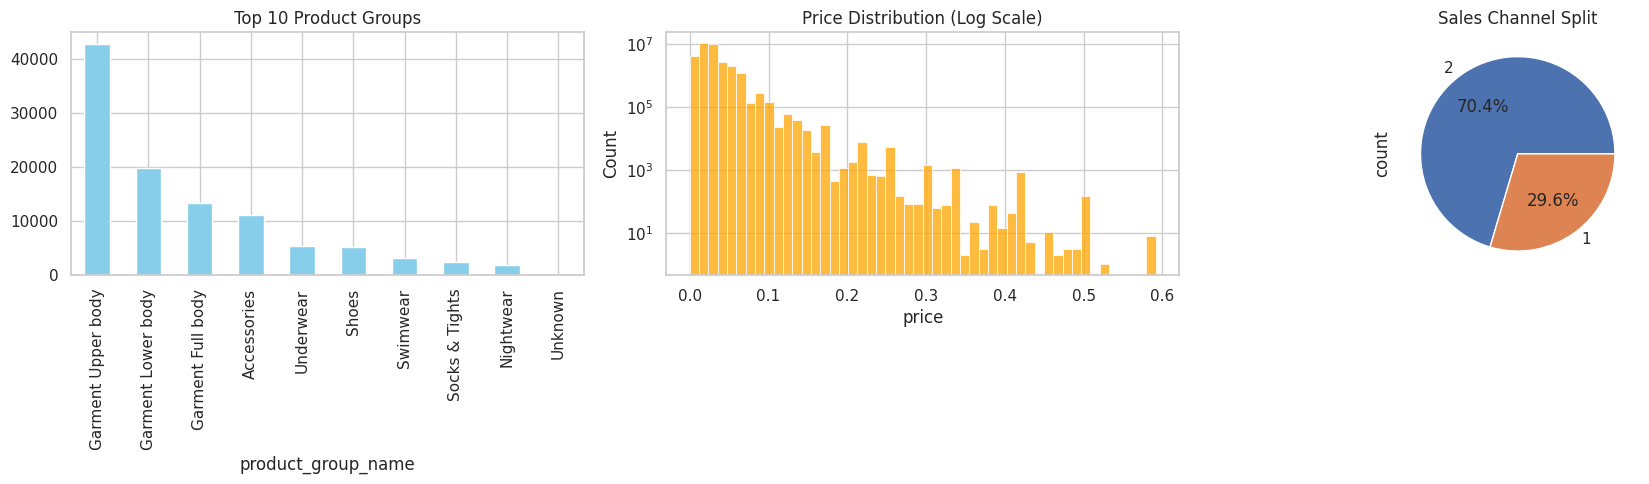


Unique Categories per Column:
  product_group_name: 19 unique values
  perceived_colour_value_name: 8 unique values
  index_code: 10 unique values
  index_name: 10 unique values
  index_group_name: 5 unique values


In [53]:
# --- CELL 1.5: EXPLORATORY DATA ANALYSIS (EDA) ---
def visualize_raw_data(articles, transactions):
    print("📊 DATA INSPECTION 📊")
    
    # 1. Feature Distributions
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    # Top Product Groups
    articles['product_group_name'].value_counts().head(10).plot(kind='bar', ax=ax[0], color='skyblue')
    ax[0].set_title('Top 10 Product Groups')
    
    # Price Distribution (Log Scale because prices vary wildly)
    sns.histplot(transactions['price'], bins=50, ax=ax[1], color='orange')
    ax[1].set_yscale('log')
    ax[1].set_title('Price Distribution (Log Scale)')
    
    # Sales Channel
    transactions['sales_channel_id'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[2])
    ax[2].set_title('Sales Channel Split')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Check for "Dominant" features
    print("\nUnique Categories per Column:")
    for col in articles.select_dtypes(include='object').columns:
        n_unique = articles[col].nunique()
        if n_unique < 20:
            print(f"  {col}: {n_unique} unique values")

# Run it
visualize_raw_data(articles_df, trans_df)

### Feature Engineering & Preprocessing
### cleaning the ram also is important

In [12]:
# --- REPLACE CELL 2 WITH THIS ---
import gc

# 1. Load Data
print("⏳ Loading Raw Data...")
articles_df, trans_df = load_data()

# 2. Engineer Features (This calls the function from Step 1)
print("⚙️ Engineering Features...")
df_res = engineer_features(articles_df, trans_df, use_ohe=False)

# --- CRITICAL MEMORY FIX ---
print("🗑️ Deleting raw Transactions to free RAM...")
del trans_df
gc.collect()
# ---------------------------

# 3. Scale Data
print("⚖️ Scaling Data...")
X_scaled, scaler = preprocess_for_clustering(df_res)

print(f"✅ Ready for training. X_scaled shape: {X_scaled.shape}")

⏳ Loading Raw Data...

[1/6] Loading Data...
  Articles shape: (105542, 25)
  Transactions shape: (31788324, 5)
⚙️ Engineering Features...

[2/6] Engineering Features (OHE=False)...
  Feature Engineering Complete. Shape: (105542, 16)
🗑️ Deleting raw Transactions to free RAM...
⚖️ Scaling Data...

[3/6] Preprocessing...
  Feature Matrix Shape: (105542, 15)
✅ Ready for training. X_scaled shape: (105542, 15)


### Train Autoencoder (The Experimentation Zone)

 Training Autoencoder...

[4/6] Training Deep Autoencoder (Latent Representation)...
Epoch 1/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.3502 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0647 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0499 - val_loss: 0.0220 - learning_rate: 0.0010
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0435 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0395 - val_loss: 0.0157 - learning_rate: 0.0010
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0338 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0322 - val_loss: 0.0129 - learning_rate: 0.0010
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━

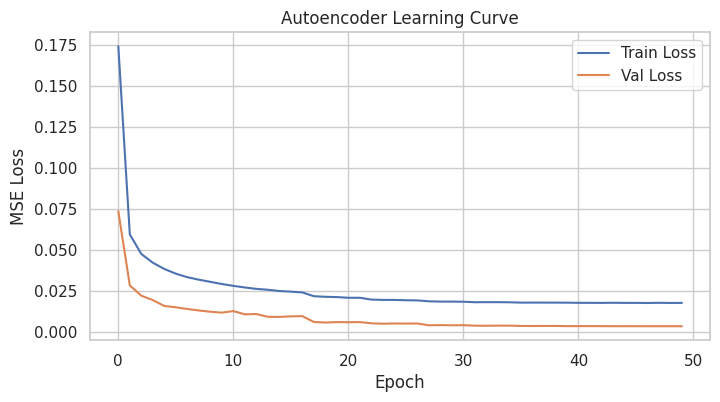

Latent Space Created.


In [31]:
# --- CELL 3: TRAIN MODEL ---
print(" Training Autoencoder...")

# 1. Build Model (You can change encoding_dim here to test 16 vs 32 vs 64)
autoencoder, encoder = build_autoencoder(X_scaled.shape[1], encoding_dim=32)

# 2. Train (Note: removed the 'save/load' logic so it ALWAYS retrains)
X_latent = train_autoencoder_prof_style(X_scaled, encoding_dim=32)

print("Latent Space Created.")

In [24]:
# --- CELL 3: DIMENSIONALITY REDUCTION (Dual-GPU Accelerated) ---
METHOD = "PCA" 

print(f"📉 Performing Dimensionality Reduction using: {METHOD}...")

# Determine safe dimensions
n_features = X_scaled.shape[1]

if METHOD == "AUTOENCODER":
    # 1. SETUP DUAL GPU STRATEGY
    # This tells TensorFlow to use BOTH T4 GPUs
    strategy = tf.distribute.MirroredStrategy()
    print(f"🚀 Number of GPUs detected: {strategy.num_replicas_in_sync}")

    # 2. Build Model INSIDE the strategy scope
    # Everything inside this 'with' block happens on all GPUs
    with strategy.scope():
        print("   Building model on GPUs...")
        autoencoder, encoder = build_autoencoder(n_features, encoding_dim=32)
        autoencoder.compile(optimizer='adam', loss='mse')

    # 3. Train (TensorFlow handles the data splitting automatically)
    # Batch size: Increase to 2048 to feed both GPUs efficiently
    print("   Starting Dual-GPU Training...")
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    )
    
    # We assume X_scaled is already in memory from Cell 2
    X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

    history = autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=2048,  # Larger batch size for GPUs
        validation_data=(X_val, X_val),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Extract Latent Space
    X_latent = encoder.predict(X_scaled, batch_size=2048)
    print("✅ Deep Latent Space created.")

elif METHOD == "PCA":
    # (Keep your existing PCA code here)
    pca = cuPCA(n_components=min(32, n_features))
    X_latent = pca.fit_transform(X_scaled)
    if hasattr(X_latent, 'get'): X_latent = X_latent.get()
    print("✅ PCA Reduction complete.")

📉 Performing Dimensionality Reduction using: PCA...
✅ PCA Reduction complete.


### Clustering & Recommendations (Instant Feedback)

 Running Clustering...

[5/6] Running Clustering Algorithms (K=15)...
  -> Running KMeans with cuML (GPU)...
  -> Running DBSCAN...
[2026-01-29 18:32:23.369] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 23678 -> 20347. Using the larger integer type might result in better performance

--- Evaluation Metrics (Latent Space) ---
K-Means Silhouette Score: 0.0918 (Higher is better)
K-Means Davies-Bouldin: 1.9875 (Lower is better)
Testing Random Article ID: 220365002


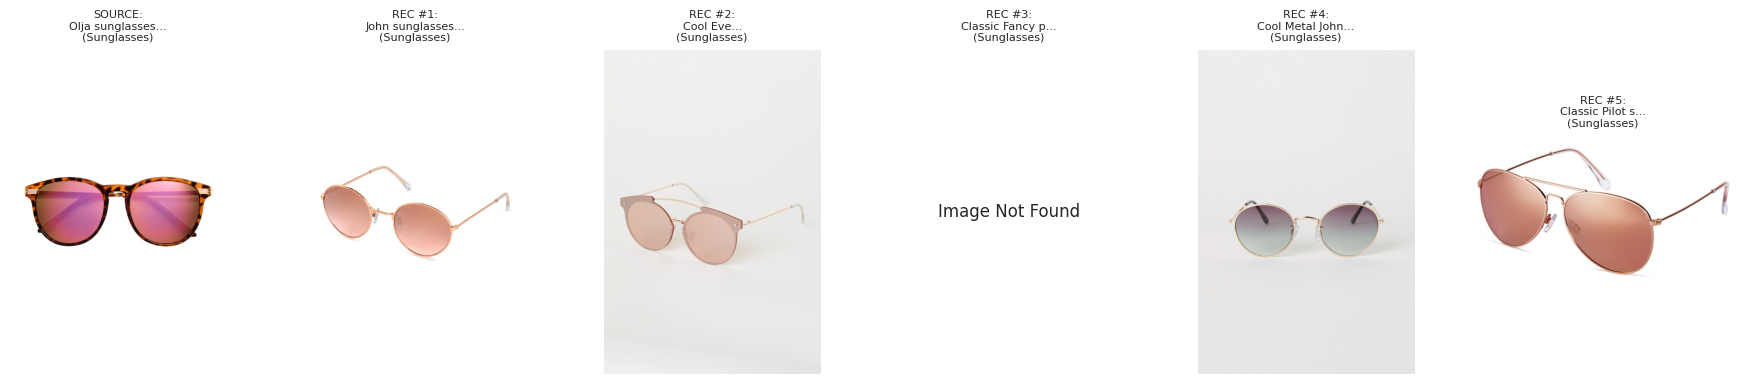

In [25]:
# --- CELL 4: CLUSTER & VISUALIZE ---
print(" Running Clustering...")

# 1. Run K-Means
clusters = run_clustering_algorithms(X_latent, n_clusters=15)

# 2. Pick a random item to test
random_id = df_res['article_id'].sample(1).iloc[0]
print(f"Testing Random Article ID: {random_id}")

# 3. Visualize Recommendations
recommend_and_visualize(
    article_id=random_id,
    df_features=df_res,
    X_latent=X_latent,     
    articles_meta=articles_df,
    top_k=5
)

 STARTING CLUSTERING BATTLE 

  -> Testing K-Means (K=10)...
  -> Testing K-Means (K=15)...
  -> Testing K-Means (K=20)...
  -> Testing DBSCAN (eps=0.5)...
[2026-01-29 20:40:00.961] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 23680 -> 20347. Using the larger integer type might result in better performance
  -> Testing DBSCAN (eps=1.0)...
[2026-01-29 20:40:07.553] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 23680 -> 20347. Using the larger integer type might result in better performance
  -> Testing DBSCAN (eps=2.0)...
[2026-01-29 20:40:13.977] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 23680 -> 20347. Using the larger integer type might result in better performance

🏆 LEADERBOARD 🏆


,Algorithm,Params,Silhouette,Davies-Bouldin
5,DBSCAN,Eps=2.0,0.540972,1.988117
1,K-Means,K=15,0.120662,1.754424
0,K-Means,K=10,0.113586,1.831268
2,K-Means,K=20,0.107288,1.788895
4,DBSCAN,Eps=1.0,-0.185650,1.454059
3,DBSCAN,Eps=0.5,-0.296136,1.167810



✅ Selected Best Model for Visualization: kmeans_15

[6/6] Visualizing Clusters (t-SNE)...


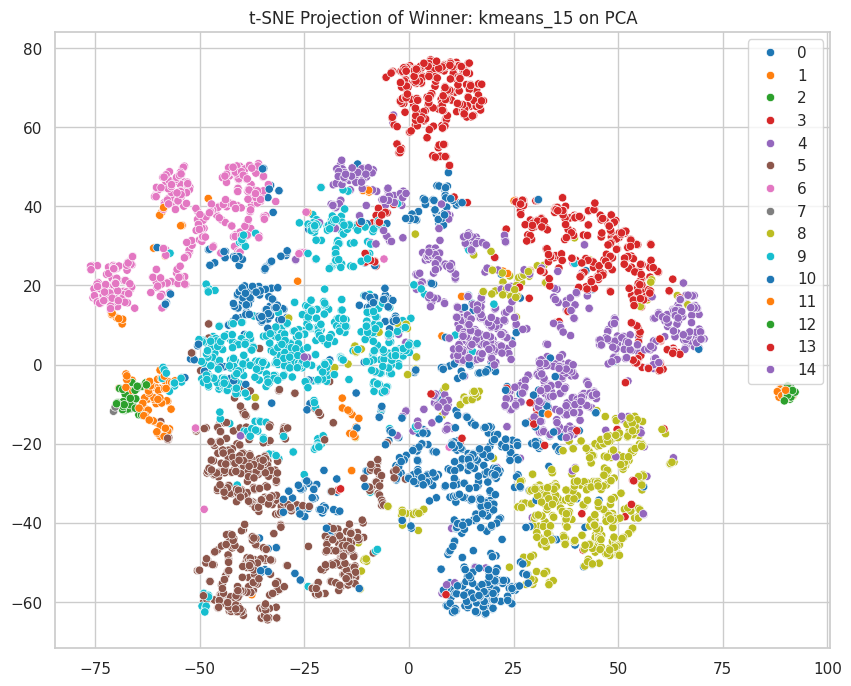

In [25]:
# --- CELL 4: CLUSTERING BATTLE & COMPARISON ---
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Settings
run_kmeans = True
run_dbscan = True 
n_clusters_list = [10, 15, 20] # Try different K values automatically

results_log = []
models = {} # Store models to use the best one later

print(" STARTING CLUSTERING BATTLE \n")

# --- 1. K-Means Loop ---
if run_kmeans:
    for k in n_clusters_list:
        print(f"  -> Testing K-Means (K={k})...")
        kmeans = cuKMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_latent)
        
        # Convert to numpy if needed
        if hasattr(labels, 'to_numpy'): labels = labels.to_numpy()
        
        # Score (Use a sample of 10k items for speed)
        # Silhouette: Higher is better (-1 to 1) | Davies-Bouldin: Lower is better (0 to inf)
        sil = silhouette_score(X_latent[:10000], labels[:10000])
        db = davies_bouldin_score(X_latent[:10000], labels[:10000])
        
        results_log.append({
            "Algorithm": "K-Means",
            "Params": f"K={k}",
            "Silhouette": sil,
            "Davies-Bouldin": db
        })
        models[f"kmeans_{k}"] = labels

# --- 2. DBSCAN Loop ---
if run_dbscan:
    # DBSCAN is sensitive. We test different epsilons.
    for eps in [0.5, 1.0, 2.0]:
        print(f"  -> Testing DBSCAN (eps={eps})...")
        dbscan = cuDBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(X_latent)
        
        if hasattr(labels, 'to_numpy'): labels = labels.to_numpy()

        # Check if DBSCAN found any clusters (sometimes it marks everything as noise -1)
        unique_labels = len(np.unique(labels))
        if unique_labels > 1:
            sil = silhouette_score(X_latent[:5000], labels[:5000])
            db = davies_bouldin_score(X_latent[:5000], labels[:5000])
        else:
            sil, db = -1, 999 # Failed clustering
            
        results_log.append({
            "Algorithm": "DBSCAN",
            "Params": f"Eps={eps}",
            "Silhouette": sil,
            "Davies-Bouldin": db
        })
        models[f"dbscan_{eps}"] = labels

# --- 3. Display Comparison Table ---
results_df = pd.DataFrame(results_log).sort_values("Silhouette", ascending=False)
print("\n🏆 LEADERBOARD 🏆")
display(results_df)

# --- 4. Select Best Model for Recommendations ---
# You can automate this or pick manually. Let's pick the best K-Means.
best_k_row = results_df[results_df['Algorithm'] == 'K-Means'].iloc[0]
best_model_name = f"kmeans_{best_k_row['Params'].split('=')[1]}"
best_labels = models[best_model_name]

print(f"\n✅ Selected Best Model for Visualization: {best_model_name}")

# Visualize the winner
visualize_clusters(X_latent, best_labels, title=f"Winner: {best_model_name} on {METHOD}")

Testing Random Article ID: 567739002


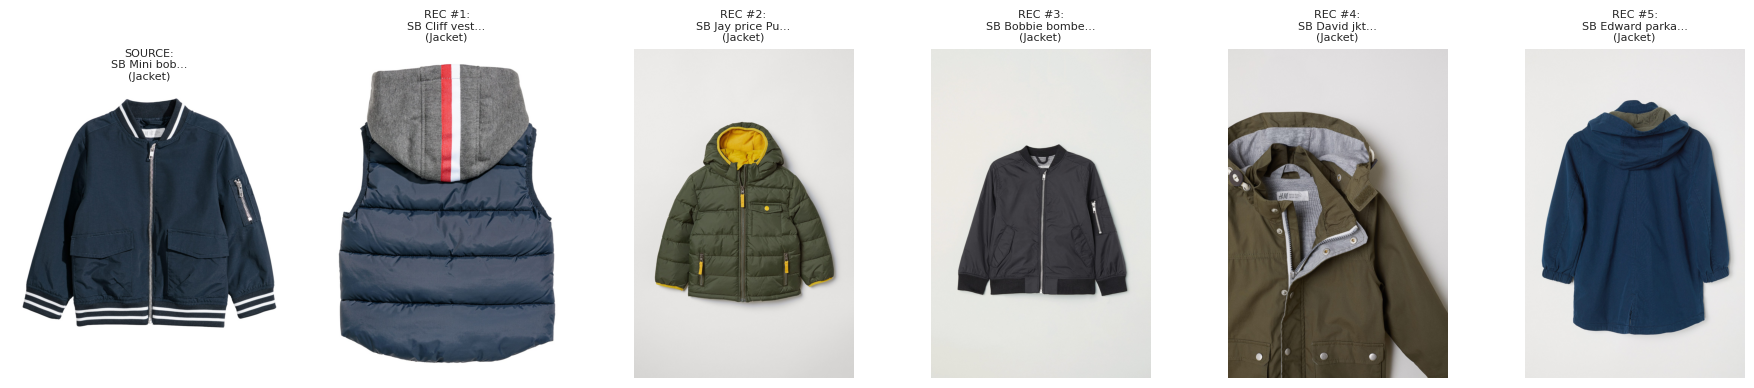

In [31]:
# --- CELL 5: Visualisation ---

# 2. Pick a random item to test
random_id = df_res['article_id'].sample(1).iloc[0]
print(f"Testing Random Article ID: {random_id}")

# 3. Visualize Recommendations
recommend_and_visualize(
    article_id=random_id,
    df_features=df_res,
    X_latent=X_latent,     
    articles_meta=articles_df,
    top_k=5
)

In [32]:
# --- CELL 6: SAVE BEST PIPELINE ---
# Assuming 'best_labels' is what you want to keep
import joblib

print("💾 Saving Best Pipeline...")
if METHOD == "AUTOENCODER":
    encoder.save("best_encoder.h5")
    print("  -> Saved Autoencoder")
elif METHOD == "PCA":
    import pickle
    with open("best_pca.pkl", "wb") as f:
        pickle.dump(pca, f)
    print("  -> Saved PCA")

# Save the labels (The "clusters")
lookup_df = pd.DataFrame({'article_id': df_res['article_id'], 'cluster': best_labels})
lookup_df.to_csv("best_clusters.csv", index=False)

# Save Scaler (Always needed)
joblib.dump(scaler, "scaler.joblib")

print("✅ All files saved.")

💾 Saving Best Pipeline...
  -> Saved PCA
✅ All files saved.


In [23]:
from ipywidgets import interact

def dynamic_recommend(category):
    # 1. Find IDs belonging to the chosen category
    category_ids = articles_df[articles_df['product_group_name'] == category]['article_id']

    # 2. Filter by IDs that actually exist in our processed features
    # (Some items might have been filtered out during cleaning)
    available_ids = category_ids[category_ids.isin(df_res['article_id'])]

    if len(available_ids) > 0:
        target_id = available_ids.sample(1).iloc[0]
        print(f"Showing recommendations for a random {category} item (ID: {target_id})")
        
        # --- FIX: Pass X_latent, NOT clusters['kmeans'] ---
        recommend_and_visualize(
            article_id=target_id, 
            df_features=df_res, 
            X_latent=X_latent,    # <--- Critical Fix
            articles_meta=articles_df
        )
    else:
        print(f"No processed data found for category: {category}")

# Run the widget - This will now be instant!
interact(dynamic_recommend, category=articles_df['product_group_name'].unique());

interactive(children=(Dropdown(description='category', options=('Garment Upper body', 'Underwear', 'Socks & Ti…

📊 GENERATING FINAL DASHBOARD... (This may take a moment)


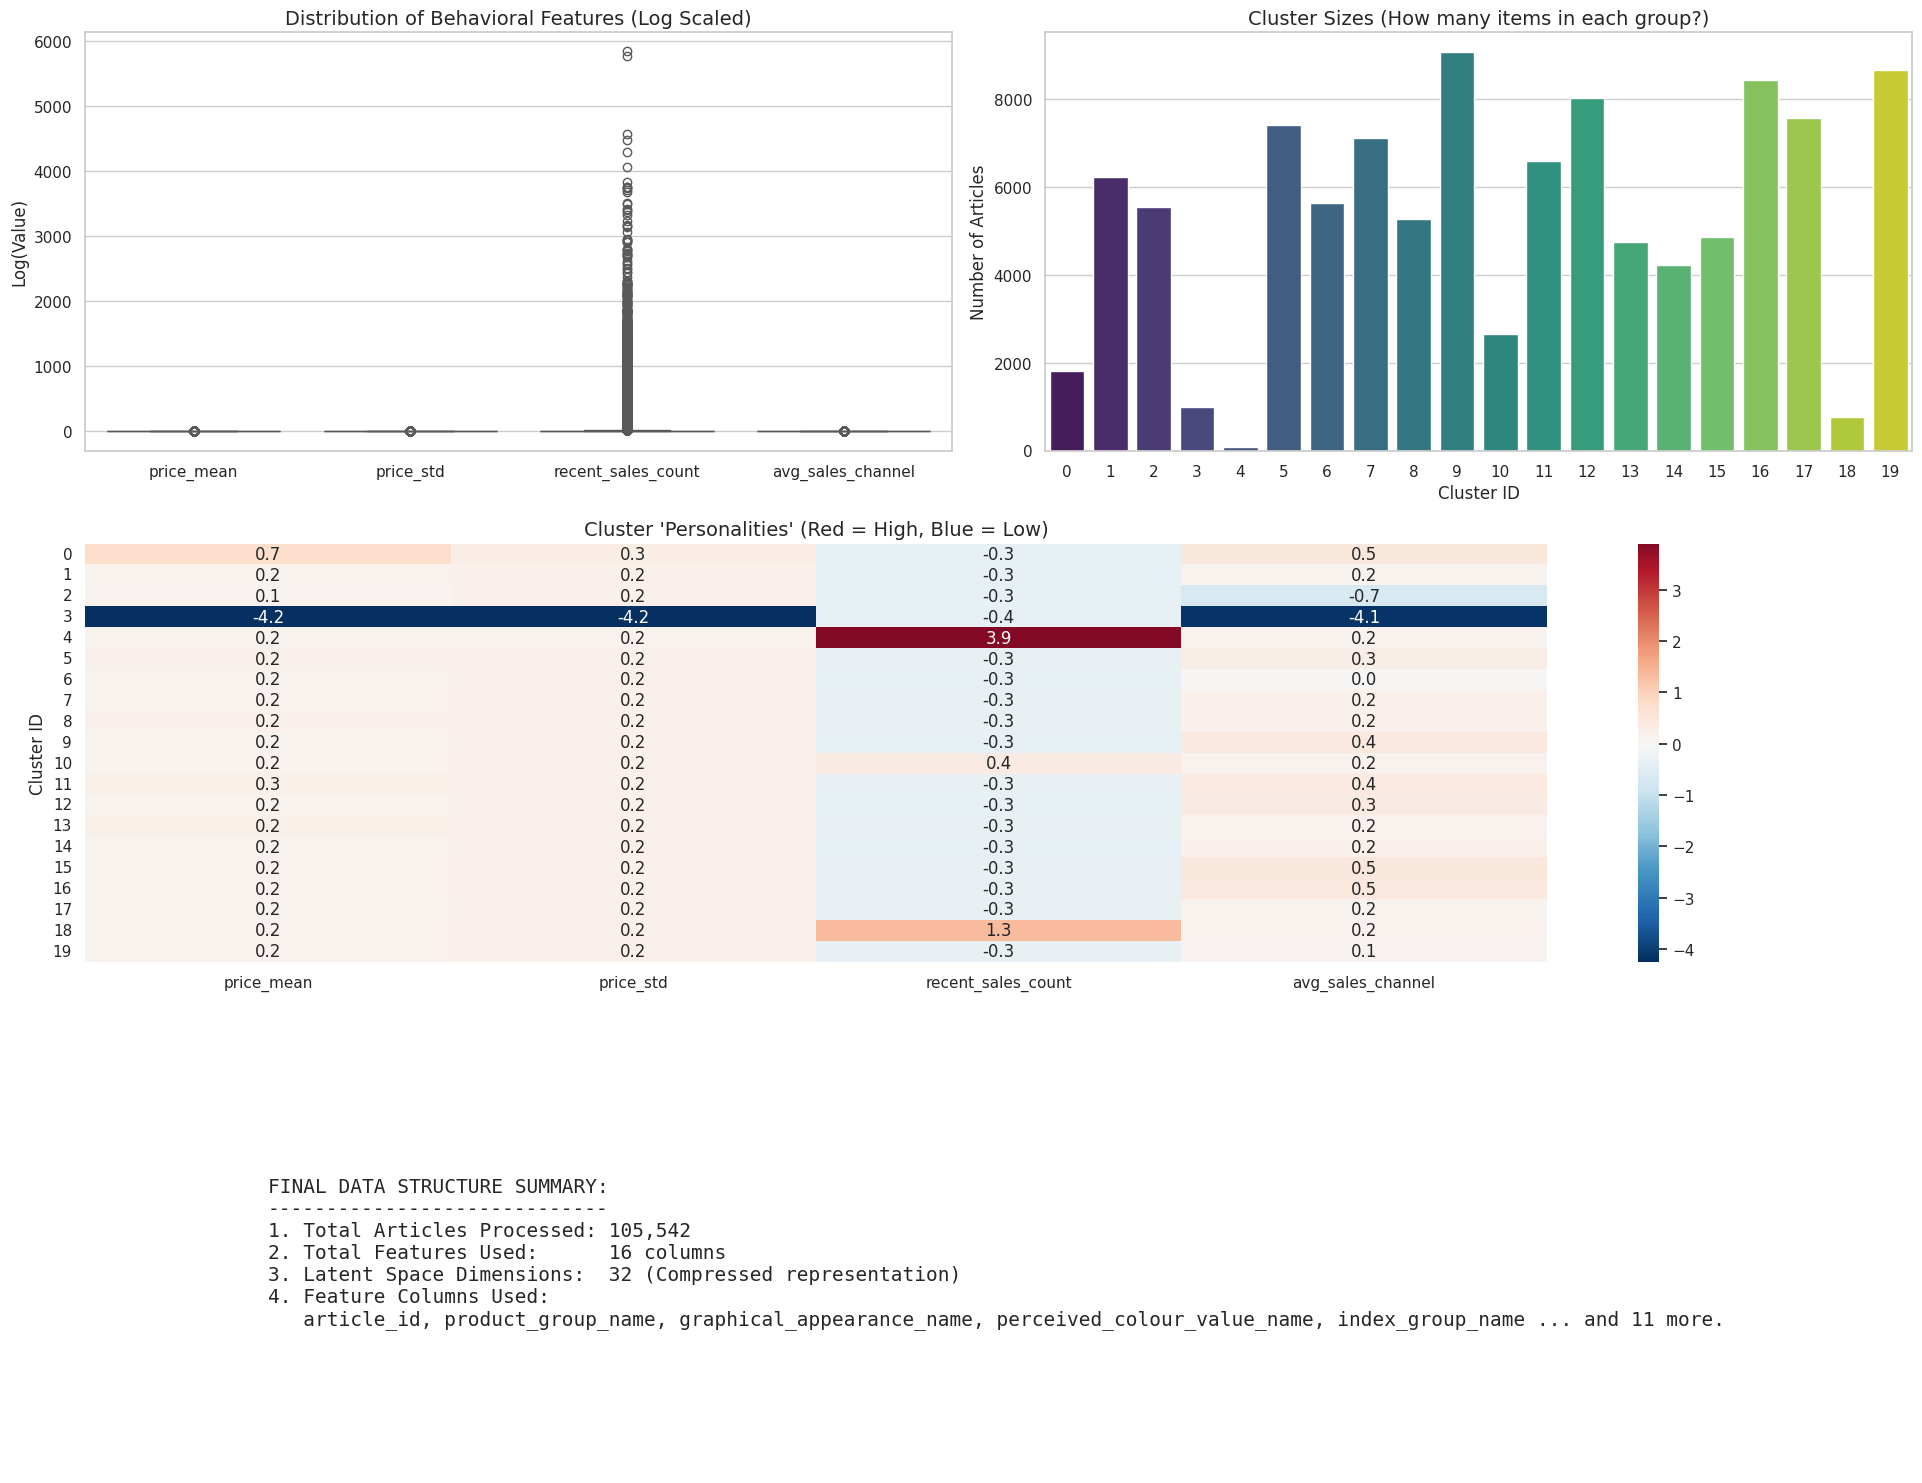

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def generate_dashboard(df_features, X_latent, labels, articles_df):
    print("📊 GENERATING FINAL DASHBOARD... (This may take a moment)")
    
    # Setup the layout
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2)
    
    # --- 1. FEATURE DISTRIBUTION (Top Left) ---
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Focus on the most important behavioral features
    key_features = ['price_mean', 'price_std', 'recent_sales_count', 'avg_sales_channel']
    
    # Normalize for visualization comparison
    plot_data = df_features[key_features].copy()
    for col in plot_data.columns:
        # Log scale for highly skewed data like sales count and price
        if plot_data[col].min() >= 0:
            plot_data[col] = np.log1p(plot_data[col])
            
    sns.boxplot(data=plot_data, ax=ax1, palette="Set2")
    ax1.set_title("Distribution of Behavioral Features (Log Scaled)", fontsize=14)
    ax1.set_ylabel("Log(Value)")

    # --- 2. CLUSTER SIZES (Top Right) ---
    ax2 = fig.add_subplot(gs[0, 1])
    unique_labels, counts = np.unique(labels, return_counts=True)
    # Remove noise (-1) from plot if using DBSCAN
    if -1 in unique_labels:
        mask = unique_labels != -1
        unique_labels = unique_labels[mask]
        counts = counts[mask]
        
    sns.barplot(x=unique_labels, y=counts, ax=ax2, palette="viridis")
    ax2.set_title("Cluster Sizes (How many items in each group?)", fontsize=14)
    ax2.set_xlabel("Cluster ID")
    ax2.set_ylabel("Number of Articles")

    # --- 3. CLUSTER PROFILES / HEATMAP (Middle Row) ---
    # This shows the "Personality" of each cluster
    ax3 = fig.add_subplot(gs[1, :])
    
    # Add cluster labels to features temporarily
    temp_df = df_features[key_features].copy()
    temp_df['Cluster'] = labels[:len(temp_df)] # Ensure length match
    
    # Calculate average feature value per cluster
    cluster_profiles = temp_df.groupby('Cluster').mean()
    
    # Normalize column-wise for heatmap (z-score)
    cluster_profiles_norm = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
    
    sns.heatmap(cluster_profiles_norm, cmap="RdBu_r", center=0, annot=True, fmt=".1f", ax=ax3)
    ax3.set_title("Cluster 'Personalities' (Red = High, Blue = Low)", fontsize=14)
    ax3.set_ylabel("Cluster ID")
    
    # --- 4. DATA SAMPLE INSPECTION (Bottom Row - Text) ---
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    
    # Create a text summary
    summary_text = (
        f"FINAL DATA STRUCTURE SUMMARY:\n"
        f"-----------------------------\n"
        f"1. Total Articles Processed: {df_features.shape[0]:,}\n"
        f"2. Total Features Used:      {df_features.shape[1]} columns\n"
        f"3. Latent Space Dimensions:  {X_latent.shape[1]} (Compressed representation)\n"
        f"4. Feature Columns Used:\n"
        f"   {', '.join(df_features.columns[:5])} ... and {len(df_features.columns)-5} more.\n"
    )
    
    ax4.text(0.1, 0.5, summary_text, fontsize=14, family='monospace', va='center')

    plt.tight_layout()
    plt.show()

# --- RUN THE DASHBOARD ---
# Ensure you pass the correct best_labels from your comparison battle
# If you haven't run the battle, use: best_labels = clusters['kmeans']
generate_dashboard(df_res, X_latent, best_labels, articles_df)

🔬 GENERATING COMPREHENSIVE DIAGNOSTIC REPORT... (Please wait)


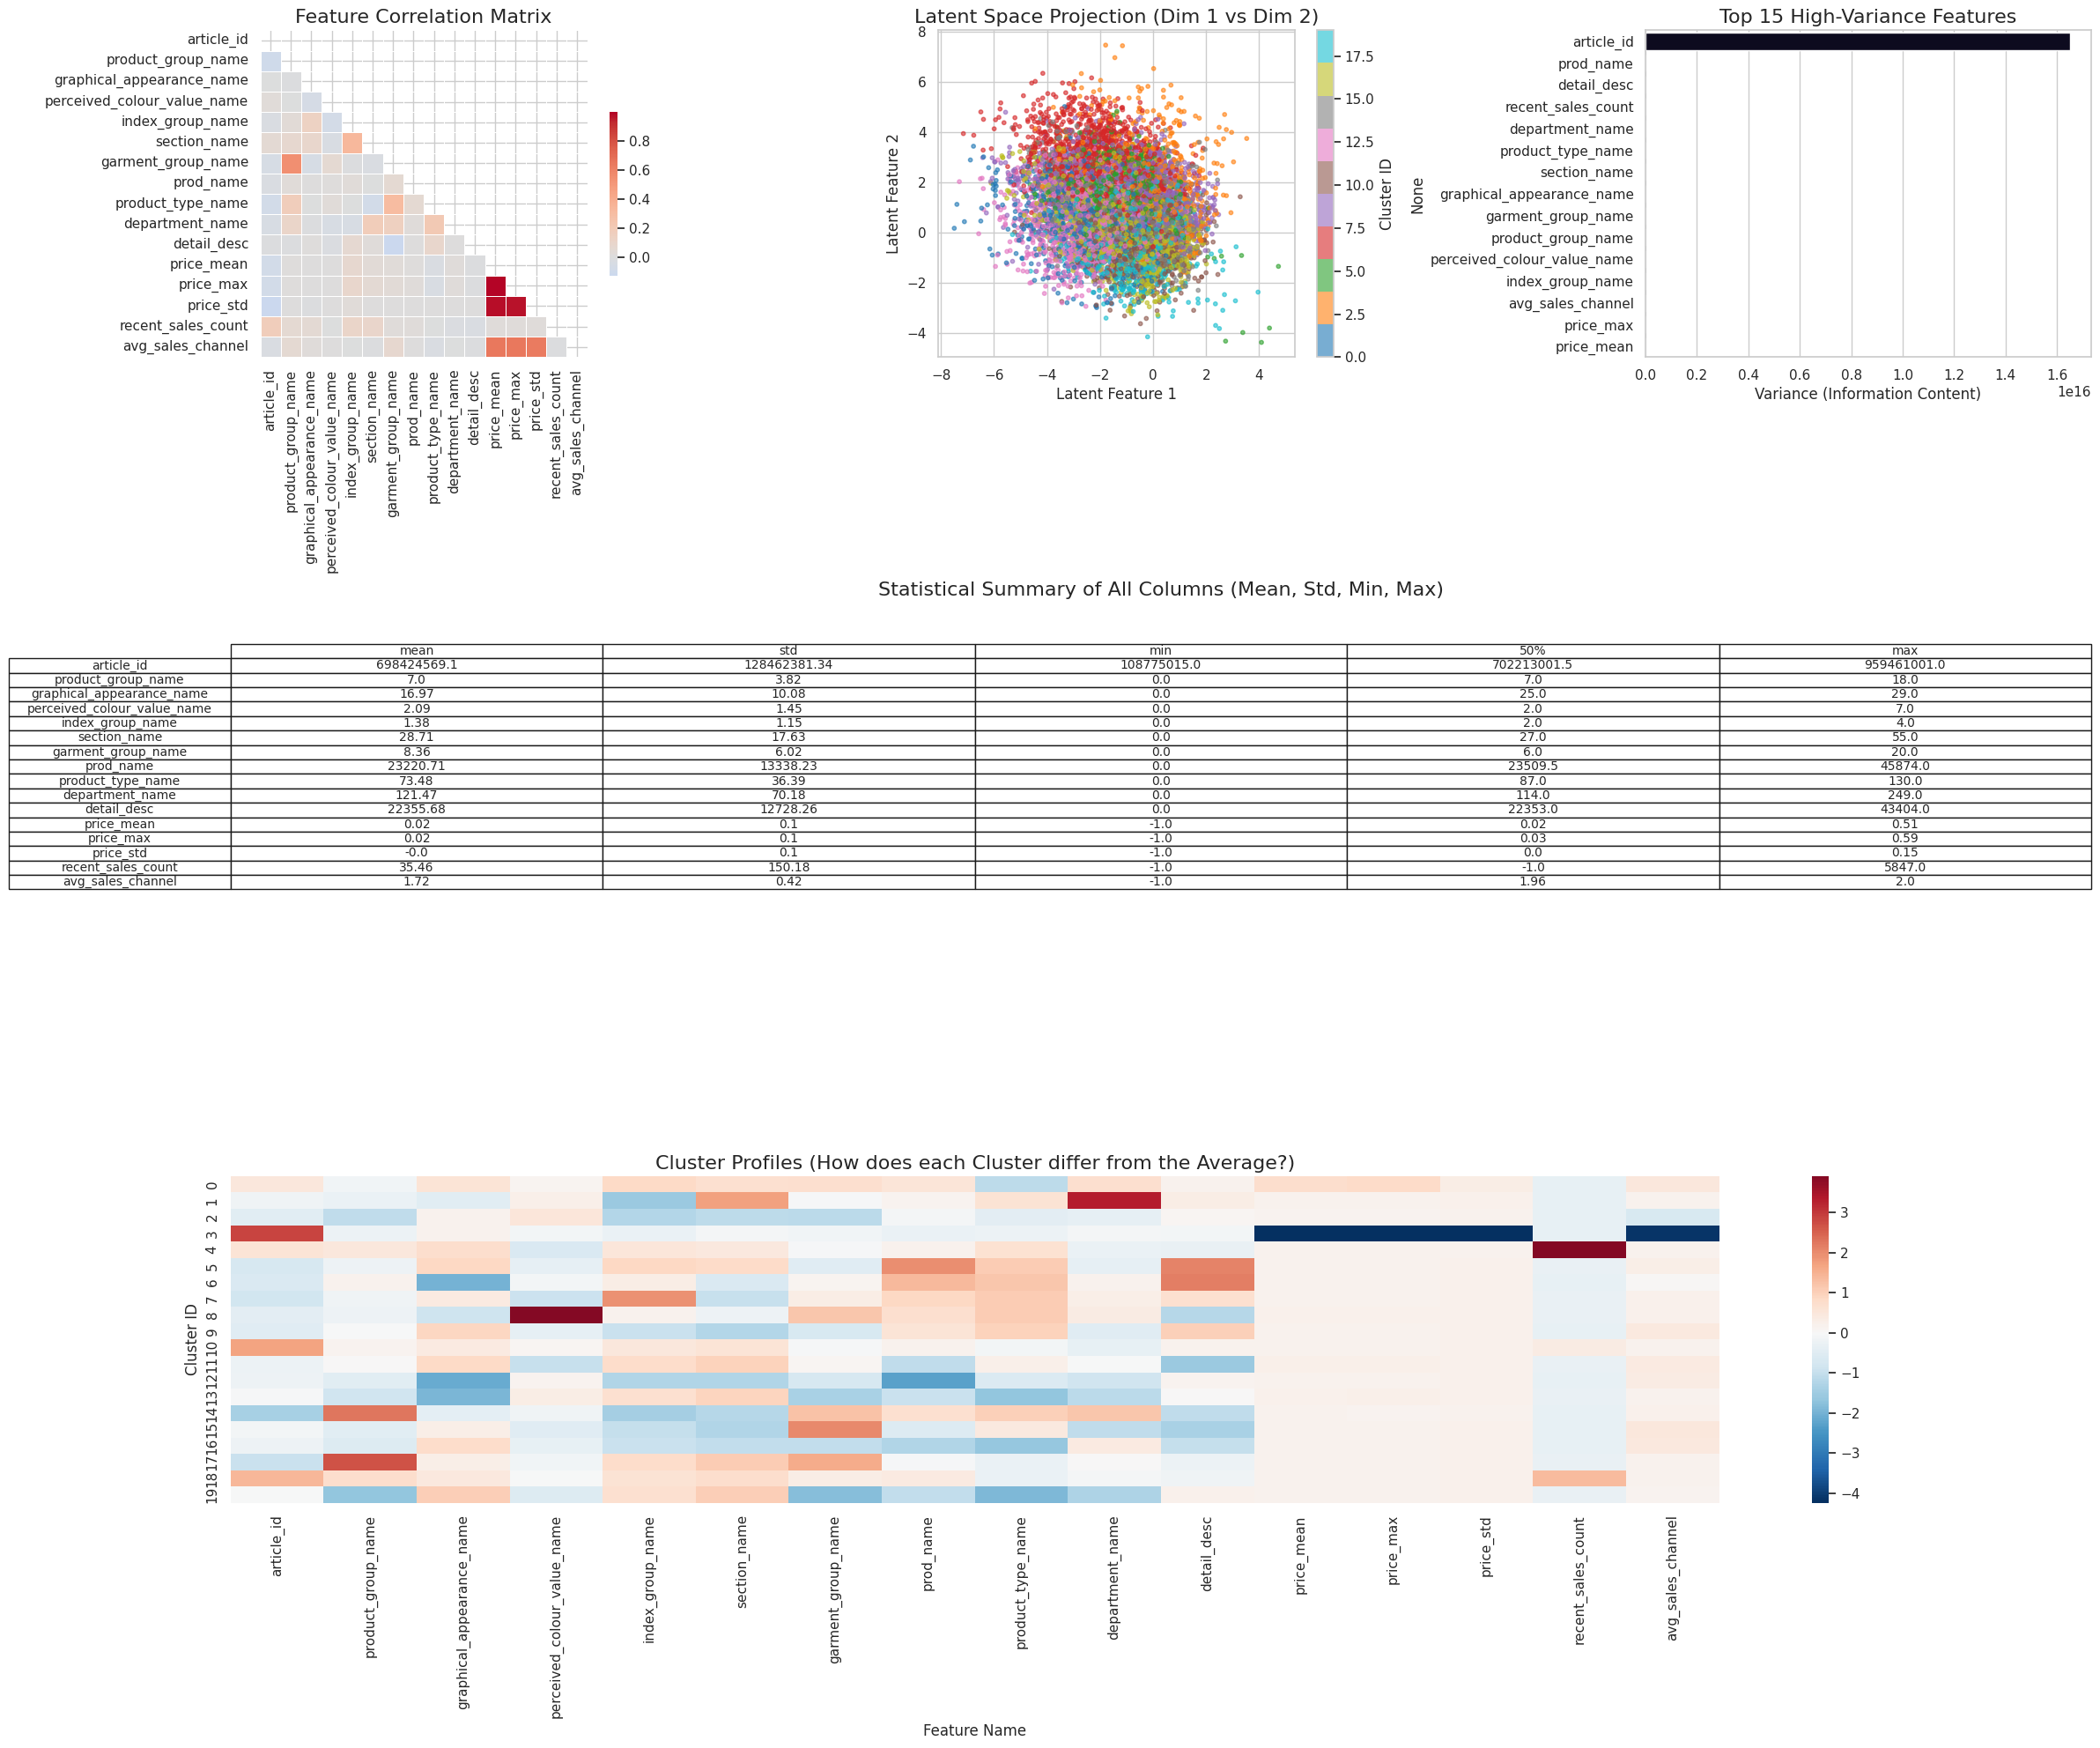

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def full_diagnostic_report(df_features, X_latent, labels):
    print("🔬 GENERATING COMPREHENSIVE DIAGNOSTIC REPORT... (Please wait)")
    
    # Create a 3-row layout
    fig = plt.figure(figsize=(24, 20))
    gs = fig.add_gridspec(3, 3)
    
    # --- 1. CORRELATION MATRIX (Top Left) ---
    # Helps you see if features are redundant (e.g., if Price Mean and Price Max are identical)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Select only numeric columns for correlation to avoid errors
    numeric_df = df_features.select_dtypes(include=[np.number])
    
    # Calculate correlation
    corr = numeric_df.corr()
    
    # Mask the upper triangle (it's symmetrical, so we don't need to see it twice)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)
    ax1.set_title("Feature Correlation Matrix", fontsize=16)

    # --- 2. LATENT SPACE SCATTER (Top Middle) ---
    # Visualizes the first 2 dimensions of what your Autoencoder/PCA actually "sees"
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Sample for speed (plotting 100k points is slow)
    idx = np.random.choice(len(X_latent), size=min(10000, len(X_latent)), replace=False)
    
    # Use the first 2 dimensions of the latent space (or PCA components)
    scatter = ax2.scatter(X_latent[idx, 0], X_latent[idx, 1], 
                         c=labels[idx], cmap='tab10', alpha=0.6, s=10)
    ax2.set_title("Latent Space Projection (Dim 1 vs Dim 2)", fontsize=16)
    ax2.set_xlabel("Latent Feature 1")
    ax2.set_ylabel("Latent Feature 2")
    fig.colorbar(scatter, ax=ax2, label='Cluster ID')

    # --- 3. FEATURE IMPORTANCE / VARIANCE (Top Right) ---
    # Shows which features vary the most (are most "interesting" to the model)
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Calculate variance of each column (scaled)
    variances = numeric_df.var().sort_values(ascending=False).head(15)
    
    sns.barplot(x=variances.values, y=variances.index, ax=ax3, palette="magma")
    ax3.set_title("Top 15 High-Variance Features", fontsize=16)
    ax3.set_xlabel("Variance (Information Content)")

    # --- 4. DETAILED STATISTICS TABLE (Middle Row) ---
    # A visual summary of "Every Column"
    ax4 = fig.add_subplot(gs[1, :])
    ax4.axis('off')
    
    # Generate statistics
    desc = df_features.describe().T  # Transpose for readability
    desc = desc[['mean', 'std', 'min', '50%', 'max']] # Select key stats
    
    # Round for display
    desc = desc.round(2)
    
    # Create the table
    table = ax4.table(cellText=desc.values,
                      colLabels=desc.columns,
                      rowLabels=desc.index,
                      cellLoc = 'center', 
                      rowLoc = 'center',
                      loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)
    ax4.set_title("Statistical Summary of All Columns (Mean, Std, Min, Max)", fontsize=16)

    # --- 5. CLUSTER PROFILES HEATMAP (Bottom Row) ---
    # Similar to the previous one, but this time for ALL features
    ax5 = fig.add_subplot(gs[2, :])
    
    # Add clusters to data
    plot_df = numeric_df.copy()
    plot_df['Cluster'] = labels[:len(plot_df)]
    
    # Group by cluster and normalize
    cluster_means = plot_df.groupby('Cluster').mean()
    cluster_means_norm = (cluster_means - cluster_means.mean()) / cluster_means.std()
    
    sns.heatmap(cluster_means_norm, cmap="RdBu_r", center=0, ax=ax5)
    ax5.set_title("Cluster Profiles (How does each Cluster differ from the Average?)", fontsize=16)
    ax5.set_xlabel("Feature Name")
    ax5.set_ylabel("Cluster ID")

    plt.tight_layout()
    plt.show()

# --- RUN THE DIAGNOSTICS ---
full_diagnostic_report(df_res, X_latent, best_labels)

### Everythin in once


[1/6] Loading Data...
ERROR! Session/line number was not unique in database. History logging moved to new session 30
  Articles shape: (105542, 25)
  Transactions shape: (31788324, 5)

[2/6] Engineering Features...

[3/6] Preprocessing...
  Feature Matrix Shape: (105542, 14)

[4/6] Training Deep Autoencoder (Latent Representation)...
Epoch 1/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.3373 - val_loss: 0.0703 - learning_rate: 0.0010
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0646 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0497 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0431 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0398 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0371 - val_loss: 0.0163 - learning_rate: 0.0010
Epo

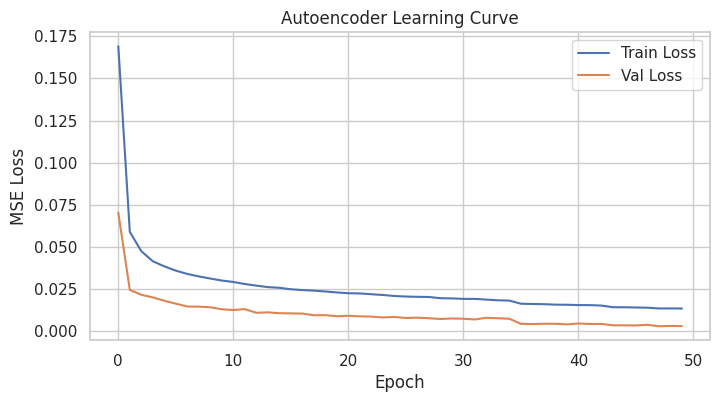


[5/6] Running Clustering Algorithms (K=15)...
  -> Running KMeans with cuML (GPU)...
  -> Running DBSCAN...
[2026-01-29 18:53:06.646] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 23678 -> 20347. Using the larger integer type might result in better performance

--- Evaluation Metrics (Latent Space) ---
K-Means Silhouette Score: 0.0962 (Higher is better)
K-Means Davies-Bouldin: 1.9863 (Lower is better)

[6/6] Visualizing Clusters (t-SNE)...


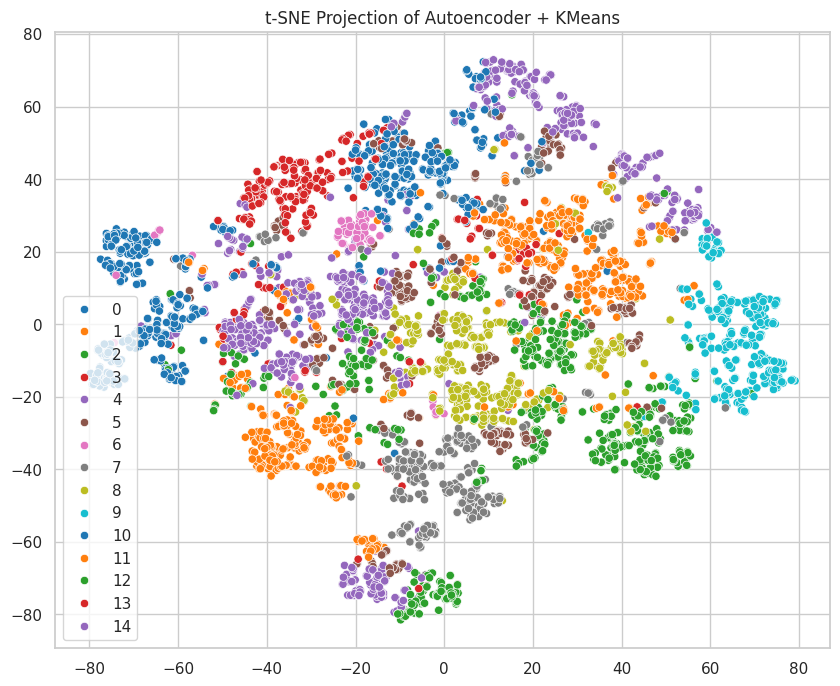


--- Recommendation Demo (Visual) ---


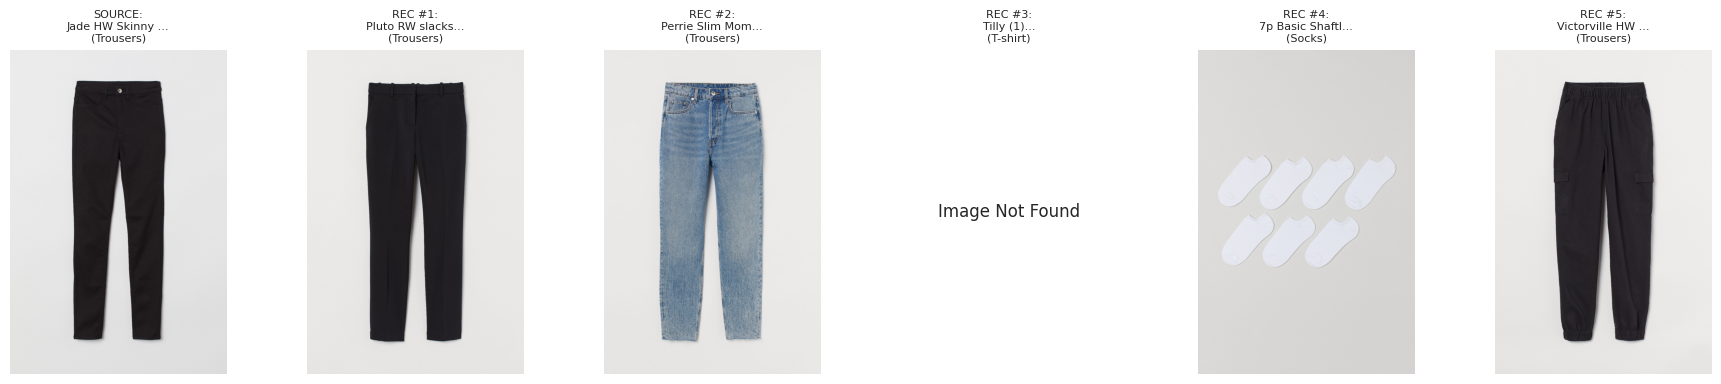

Testing Random Article ID: 736944009


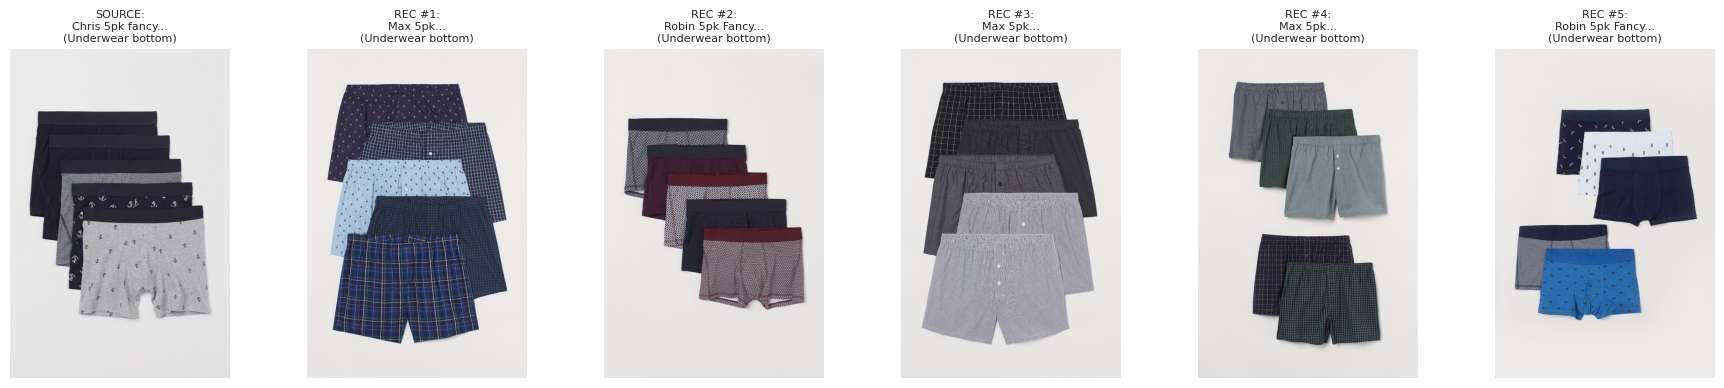

In [30]:
if __name__ == "__main__":
    # 1. Run Pipeline and unpack ALL 7 variables (X_latent was missing)
    df_res, clusters, articles_df, trans_df, encoder, scaler, X_latent = main_pipeline()

    # 2. Pick a random article ID from the existing feature set
    random_id = df_res['article_id'].sample(1).iloc[0]

    print(f"Testing Random Article ID: {random_id}")

    # 3. Test the NEW distance-based recommender
    recommend_and_visualize(
        article_id=random_id,
        df_features=df_res,
        X_latent=X_latent,     # Pass the vector space we just unpacked
        articles_meta=articles_df,
        top_k=5
    )